# 최적의 토픽 개수 구하기 및 LDA 토픽 모델링 시행

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [2]:
df = pd.read_csv('Dataset_preprocessed.csv')
df.head()

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,1.601001e+06,20221031,전북도민일보,남형진 기자,"한국탄소산업진흥원, 탄소소부장 기업 기술 애로 지원 박차",IT_과학>과학,지역>대전,지역>충남,NaN,NaN,NaN,방윤혁,"신성,한국탄소산업진흥원,진흥원","소부장 융합혁신지원단,소부장혁신지원,대성중공업,우주항공,카텍에이치,진흥원","한국탄소산업진흥원,탄소소부장,기업,애로,지원,박차,한국탄소산업진흥원,원장,방윤혁,소...","진흥원,전문가,탄소소부장,소부장,한국탄소산업진흥원,자동차,수거장치,기술애,소부장혁신...",한국탄소산업진흥원(원장 방윤혁)이 국내 탄소 소재ㆍ부품ㆍ장비 기업의 현장 기술애로 ...,http://www.domin.co.kr/news/articleView.html?i...,NaN
1,7.100501e+06,20221031,전자신문,정다은,"[ET단상]자원순환, 포장재 '탈(脫) 플라스틱'에 달렸다",사회>환경,경제>유통,경제>자원,NaN,NaN,NaN,김지선,"한국,설령","환경부,FSC(산림관리협의회,자원,플라스틱,산업통상자원부,PCR","자원순환,포장재,플라스틱,플라스틱,인류,발명,최고,선물,최악,산물,유용성,편리,장점...","친환경,생활공작소,생활용품업계,재활용,포장재,배출량,폐기물,코로나19,순환경제,탄소...",플라스틱은 인류가 발명한 '최고의 선물이자 최악의 산물'이다. 가볍고 견고하다는 유...,http://www.etnews.com/20221031000039,NaN
2,2.100311e+06,20221031,서울경제,"유주희 기자,팀지구용 기자","해변의 불꽃놀이, '불법'입니다[지구용]",미분류,NaN,NaN,사회>사회갈등>시위,NaN,NaN,NaN,"지구,인천,저도,인천시,을왕리","시셰퍼드,CU,이마트24,의원실,해양수산부,세븐일레븐,GS25,국민의힘","해변,불꽃놀이,불법,지구용,해수욕장법,폭죽,판매,합법,단속,인력,어둠,해변,파도,소...","폭죽놀이,시셰퍼드,활동가,바닷가,불꽃놀이,지구용,활동가님,편의점,정철,폭죽놀,현수막...","어둠이 내려앉은 해변의 파도 소리, 손에는 맥주 한 캔, 속마음을 실어나르는 대화,...",http://www.sedaily.com/NewsView/26CKC2064U,NaN
3,2.100801e+06,20221028,아시아경제,영남취재본부 황두열,"부경대, 중학교 찾아 ‘청소년 해역인문학 강연’ 개최",지역>부산,지역>대전,IT_과학>IT_과학일반,NaN,NaN,NaN,"권영주,김학준,김찬희,문혜진,강호영","인문한국플러스,해역,해산,부산,해운대,영남","진로,KIOST,HK,HK+)사업단,정책연구원,HK+사업단,국립부경대학교,부흥중,부...","부경대,중학교,강연,청소년,해역,인문학,개최,국립,부경대학교,인문,한국플러스,HK,...","부경대,인문학,해양과학,부산,권영주,학생들,문혜진,hk,부산대,강호영,부흥중학교,김...",[아시아경제 영남취재본부 황두열 기자] 국립부경대학교 인문한국플러스(HK+)사업단이...,https://view.asiae.co.kr/article/2022102817342...,NaN
4,1.500701e+06,20221028,부산일보,김예빈,"부경대, 중학교 찾아 ‘청소년 해역인문학 강연’ 개최",지역>부산,IT_과학>IT_과학일반,지역>대전,NaN,NaN,NaN,"권영주,김학준,김찬희,문혜진,손동주,강호영","인문한국플러스,해역,HK+)사업단,해산,부산,해운대","진로,KIOST,정책연구원,HK+사업단,국립부경대학교,부흥중,부경대,부흥중학교,부산대","부경대,중학교,강연,청소년,해역,인문학,개최,24일,27일,부흥중,국립,부경대학교,...","인문학,부경대,부흥중,부산,문혜진,해양과학,권영주,부산대,hk,학생들,강호영,사업단...",국립부경대학교 인문한국플러스(HK+)사업단(단장 손동주)은 24일과 27일 양일간 ...,https://www.busan.com/view/busan/view.php?code...,NaN


### 키워드만 가지고 진행할 예정이기 때문에, 쓸모없는 칼럼들은 제거를 하고 시작할 예정

In [3]:
df.columns

Index(['뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2', '통합 분류3',
       '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관', '키워드',
       '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부'],
      dtype='object')

In [4]:
# 불필요 칼럼 제거
df = df[['키워드']]

In [5]:
# 결과 확인
df

,키워드
0,"한국탄소산업진흥원,탄소소부장,기업,애로,지원,박차,한국탄소산업진흥원,원장,방윤혁,소..."
1,"자원순환,포장재,플라스틱,플라스틱,인류,발명,최고,선물,최악,산물,유용성,편리,장점..."
2,"해변,불꽃놀이,불법,지구용,해수욕장법,폭죽,판매,합법,단속,인력,어둠,해변,파도,소..."
3,"부경대,중학교,강연,청소년,해역,인문학,개최,국립,부경대학교,인문,한국플러스,HK,..."
4,"부경대,중학교,강연,청소년,해역,인문학,개최,24일,27일,부흥중,국립,부경대학교,..."
...,...
2395,"2년,IFA,삼성,LG,공개,가전,유럽,최대,가전,박람회,IFA,삼성,LG,참여,트..."
2396,"수원사업장,부회장,이재용,삼성전자,MZ,세대,직원,소통,복권,대외,일정,현장,용인,..."
2397,"가방,페트병,재활용,지구용,폐페트병,플리츠마마,니트백,사진,가방,용사님,브랜드,이름..."
2398,"삼성전자,파타고니아,협력,공개,미세,플라스틱,저감,세탁기,삼성전자,글로벌,아웃도어,..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   키워드     2400 non-null   object
dtypes: object(1)
memory usage: 18.9+ KB


In [7]:
okt = Okt()
tokenized_data = []

for sentence in df['키워드']:
    temp_X = okt.nouns(sentence)
    tokenized_data.append(temp_X)
    
pd.DataFrame(tokenized_data)

,0,1,2,3,4,5,6,7,8,9,...,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077
0,한국,탄소,산업,진흥,탄소,부장,기업,애로,지원,박차,...,None,None,None,None,None,None,None,None,None,None
1,자원,순환,포장재,플라스틱,플라스틱,인류,발명,최고,선물,최악,...,None,None,None,None,None,None,None,None,None,None
2,해변,불꽃놀이,불법,지구,용,해수욕장,법,폭죽,판매,합법,...,None,None,None,None,None,None,None,None,None,None
3,부경대,중학교,강연,청소년,해역,인문학,개최,국립,부경대학교,인문,...,None,None,None,None,None,None,None,None,None,None
4,부경대,중학교,강연,청소년,해역,인문학,개최,부흥,국립,부경대학교,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,삼성,공개,가전,유럽,최대,가전,박람회,삼성,참여,트렌드,...,None,None,None,None,None,None,None,None,None,None
2396,사업,부회장,이재용,삼성,전자,세대,직원,소통,복권,대외,...,None,None,None,None,None,None,None,None,None,None
2397,가방,페트병,재활용,지구,용,폐,페트병,리츠,마마,니트,...,None,None,None,None,None,None,None,None,None,None
2398,삼성,전자,파타고니아,협력,공개,미세,플라스틱,감,세탁기,삼성,...,None,None,None,None,None,None,None,None,None,None


In [8]:
df2=pd.DataFrame(tokenized_data)
df2[2000].value_counts()

마     1
지구    1
Name: 2000, dtype: int64

split_df = df['키워드'].str.split(',', expand=True)
split_df

In [24]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.2 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 11.0 MB/s eta 0:00:0000:0100:01
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=0fb968127ad6842432450937b267432d81122793d0cc52fdfdeacc47c49a4014
  Stored in directory: /Users/leeshinhaeng/Library/Caches/pip/wheels/62/73/dd/e1723cb4dfe5b31bf4719e640a6f9a28f488225e0af46a3514
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2936 sha256=cf62bb09f98767cb73532795166759f3f7b9fa2f87b83966123feda2ae2f92a4
  Stored in directory: /Users/leeshinhaeng/Library/Caches/pip/wheels/1c/2f/26/476423e3abcbdc095c9061b4a385339f4d5c4952c036ef8262
Successfully built pyLDAvis s

/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
100%|████████████████████████████████████| 9690/9690 [00:00<00:00, 11541.93it/s]
2023-01-12 23:02:29,783 : INFO : using symmetric alpha at 0.5
2023-01-12 23:02:29,784 : INFO : using symmetric eta at 0.5
2023-01-12 23:02:29,785 : INFO : using serial LDA version on this node
2023-01-12 23:02:29,789 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 9690 documents, updating model once every 2000 documents, evaluating perplexity every 9690 documents, iterating 50x with a convergence threshold of 0.001000
2023-01-12 23:02:29,789 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-01-12 23:02:29,789 : INFO : PROGRESS: pass 0, 

Number of unique tokens: 5215
Number of documents: 9690


2023-01-12 23:02:30,104 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:02:30,107 : INFO : topic #0 (0.500): 0.004*"소재" + 0.004*"담배꽁초" + 0.003*"대표" + 0.003*"환경부" + 0.003*"교수" + 0.003*"한강" + 0.003*"중국" + 0.003*"제거" + 0.003*"정책" + 0.003*"한국"
2023-01-12 23:02:30,108 : INFO : topic #1 (0.500): 0.007*"아이스팩" + 0.004*"활동" + 0.004*"지원" + 0.004*"자원" + 0.003*"실천" + 0.003*"소재" + 0.003*"대표" + 0.003*"시장" + 0.003*"환경오염" + 0.003*"서울"
2023-01-12 23:02:30,108 : INFO : topic diff=1.173565, rho=1.000000
2023-01-12 23:02:30,108 : INFO : PROGRESS: pass 0, at document #4000/9690
2023-01-12 23:02:30,414 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:02:30,415 : INFO : topic #0 (0.500): 0.006*"담배꽁초" + 0.004*"부표" + 0.004*"소재" + 0.004*"인천" + 0.003*"중국" + 0.003*"해양쓰레기" + 0.003*"한국" + 0.003*"환경부" + 0.003*"스티로폼" + 0.003*"정책"
2023-01-12 23:02:30,416 : INFO : topic #1 (0.500): 0.017*"아이스팩" + 0.005*"자원" + 0.005*"코로나19" + 0.004*"재사용" 

2023-01-12 23:02:34,983 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-01-12 23:02:34,984 : INFO : PROGRESS: pass 0, at document #2000/9690
2023-01-12 23:02:35,315 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:02:35,317 : INFO : topic #0 (0.250): 0.005*"소재" + 0.004*"자원" + 0.003*"활동" + 0.003*"섭취" + 0.003*"교수" + 0.003*"아이스팩" + 0.003*"담배꽁초" + 0.003*"캠페인" + 0.003*"연구팀" + 0.003*"분야"
2023-01-12 23:02:35,317 : INFO : topic #1 (0.250): 0.004*"소재" + 0.004*"교수" + 0.004*"대표" + 0.004*"한강" + 0.004*"서울" + 0.004*"정책" + 0.003*"산업" + 0.003*"지원" + 0.003*"물티슈" + 0.003*"자원"
2023-01-12 23:02:35,318 : INFO : topic #2 (0.250): 0.005*"아이스팩" + 0.004*"지원" + 0.004*"시장" + 0.004*"담배꽁초" + 0.003*"대표" + 0.003*"소금" + 0.003*"환경부" + 0.003*"식품" + 0.003*"서울" + 0.003*"환경오염"
2023-01-12 23:02:35,318 : INFO : topic #3 (0.250): 0.005*"아이스팩" + 0.004*"삼성전자" + 0.004*"활동" + 0.004*"소재" + 0.004*"지원" 

2023-01-12 23:02:39,535 : INFO : 24 batches submitted to accumulate stats from 1536 documents (266576 virtual)
2023-01-12 23:02:39,560 : INFO : 25 batches submitted to accumulate stats from 1600 documents (277738 virtual)
2023-01-12 23:02:39,641 : INFO : 26 batches submitted to accumulate stats from 1664 documents (288034 virtual)
2023-01-12 23:02:39,657 : INFO : 27 batches submitted to accumulate stats from 1728 documents (298945 virtual)
2023-01-12 23:02:39,664 : INFO : 28 batches submitted to accumulate stats from 1792 documents (309930 virtual)
2023-01-12 23:02:39,679 : INFO : 29 batches submitted to accumulate stats from 1856 documents (320438 virtual)
2023-01-12 23:02:39,687 : INFO : 30 batches submitted to accumulate stats from 1920 documents (330549 virtual)
2023-01-12 23:02:39,698 : INFO : 31 batches submitted to accumulate stats from 1984 documents (341147 virtual)
2023-01-12 23:02:39,723 : INFO : 32 batches submitted to accumulate stats from 2048 documents (351727 virtual)
2

2023-01-12 23:02:42,181 : INFO : topic #5 (0.167): 0.006*"소금" + 0.005*"검출" + 0.004*"소재" + 0.004*"화학" + 0.004*"인체" + 0.004*"화장품" + 0.004*"한국" + 0.004*"우리나라" + 0.004*"일본" + 0.004*"바이오"
2023-01-12 23:02:42,181 : INFO : topic diff=0.463177, rho=0.447214
2023-01-12 23:02:42,182 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=5215, num_topics=6, decay=0.5, chunksize=2000) in 1.85s', 'datetime': '2023-01-12T23:02:42.182033', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-01-12 23:02:42,183 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2023-01-12 23:02:42,819 : INFO : 1 batches submitted to accumulate stats from 64 documents (12209 virtual)
2023-01-12 23:02:42,828 : INFO : 2 batches submitted to accumulate stats from 128 documents (23816 virtual)
2023-01-12 23:02:42,834 : INFO : 3 batc

2023-01-12 23:02:46,899 : INFO : topic #1 (0.125): 0.007*"인류" + 0.006*"교수" + 0.006*"분야" + 0.005*"과학" + 0.005*"정책" + 0.005*"바이러스" + 0.005*"한국" + 0.004*"지원" + 0.004*"코로나19" + 0.004*"국가"
2023-01-12 23:02:46,899 : INFO : topic #0 (0.125): 0.009*"연구진" + 0.008*"연구팀" + 0.007*"발견" + 0.007*"섬유" + 0.006*"영국" + 0.005*"자연" + 0.005*"교수" + 0.005*"입자" + 0.004*"생물" + 0.004*"섭취"
2023-01-12 23:02:46,900 : INFO : topic #2 (0.125): 0.030*"마스크" + 0.007*"코로나19" + 0.005*"발견" + 0.004*"미세먼지" + 0.004*"영국" + 0.004*"사람들" + 0.004*"연구진" + 0.004*"성분" + 0.004*"착용" + 0.004*"코로나"
2023-01-12 23:02:46,900 : INFO : topic #7 (0.125): 0.007*"생각" + 0.006*"소금" + 0.004*"대표" + 0.004*"변화" + 0.004*"실천" + 0.004*"자연" + 0.004*"서울" + 0.004*"관심" + 0.004*"학교" + 0.004*"소재"
2023-01-12 23:02:46,901 : INFO : topic #6 (0.125): 0.030*"아이스팩" + 0.008*"코로나19" + 0.007*"재사용" + 0.004*"증가" + 0.004*"설치" + 0.004*"자원" + 0.004*"중국" + 0.004*"환경오염" + 0.004*"사용량" + 0.004*"활동"
2023-01-12 23:02:46,901 : INFO : topic diff=0.741413, rho=0.577350
2023-01-12 23

2023-01-12 23:02:51,503 : INFO : accumulated word occurrence stats for 413393 virtual documents
2023-01-12 23:02:51,679 : INFO : using symmetric alpha at 0.1
2023-01-12 23:02:51,680 : INFO : using symmetric eta at 0.1
2023-01-12 23:02:51,681 : INFO : using serial LDA version on this node
2023-01-12 23:02:51,685 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 9690 documents, updating model once every 2000 documents, evaluating perplexity every 9690 documents, iterating 50x with a convergence threshold of 0.001000
2023-01-12 23:02:51,685 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-01-12 23:02:51,686 : INFO : PROGRESS: pass 0, at document #2000/9690
2023-01-12 23:02:52,013 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:02:52,015 : INFO : topic #4 (0.100): 0.006*"물티슈" + 0.004*"환경부" + 0.003*"생각" + 0.003*"

2023-01-12 23:02:55,830 : INFO : 10 batches submitted to accumulate stats from 640 documents (115137 virtual)
2023-01-12 23:02:55,895 : INFO : 11 batches submitted to accumulate stats from 704 documents (125924 virtual)
2023-01-12 23:02:55,945 : INFO : 12 batches submitted to accumulate stats from 768 documents (137988 virtual)
2023-01-12 23:02:56,028 : INFO : 13 batches submitted to accumulate stats from 832 documents (149557 virtual)
2023-01-12 23:02:56,038 : INFO : 14 batches submitted to accumulate stats from 896 documents (160445 virtual)
2023-01-12 23:02:56,096 : INFO : 15 batches submitted to accumulate stats from 960 documents (169459 virtual)
2023-01-12 23:02:56,174 : INFO : 16 batches submitted to accumulate stats from 1024 documents (181848 virtual)
2023-01-12 23:02:56,181 : INFO : 17 batches submitted to accumulate stats from 1088 documents (193947 virtual)
2023-01-12 23:02:56,194 : INFO : 18 batches submitted to accumulate stats from 1152 documents (201670 virtual)
2023-01

2023-01-12 23:02:58,866 : INFO : topic #8 (0.083): 0.008*"중국" + 0.007*"인류" + 0.007*"바다거북" + 0.006*"일본" + 0.006*"폐플라스틱" + 0.005*"미세먼지" + 0.005*"코로나19" + 0.005*"페트병" + 0.005*"우리나라" + 0.005*"영국"
2023-01-12 23:02:58,867 : INFO : topic #9 (0.083): 0.019*"소금" + 0.008*"물티슈" + 0.008*"발견" + 0.008*"천일염" + 0.007*"고래" + 0.006*"성분" + 0.005*"태평양" + 0.005*"소비자" + 0.005*"티백" + 0.005*"북극"
2023-01-12 23:02:58,867 : INFO : topic diff=0.739740, rho=0.500000
2023-01-12 23:02:59,237 : INFO : -8.210 per-word bound, 296.1 perplexity estimate based on a held-out corpus of 1690 documents with 66414 words
2023-01-12 23:02:59,238 : INFO : PROGRESS: pass 0, at document #9690/9690
2023-01-12 23:02:59,469 : INFO : merging changes from 1690 documents into a model of 9690 documents
2023-01-12 23:02:59,472 : INFO : topic #10 (0.083): 0.008*"분야" + 0.007*"산업" + 0.006*"안전" + 0.005*"과학" + 0.005*"한국" + 0.005*"지원" + 0.005*"바이오" + 0.004*"대응" + 0.004*"국가" + 0.004*"강화"
2023-01-12 23:02:59,472 : INFO : topic #11 (0.083): 0.016*"

2023-01-12 23:03:04,185 : INFO : topic #13 (0.071): 0.007*"아이스팩" + 0.006*"대표" + 0.005*"자원" + 0.005*"한강" + 0.004*"산업" + 0.003*"폐플라스틱" + 0.003*"바이오" + 0.003*"인천" + 0.003*"지원" + 0.003*"설치"
2023-01-12 23:03:04,186 : INFO : topic diff=3.276204, rho=1.000000
2023-01-12 23:03:04,187 : INFO : PROGRESS: pass 0, at document #4000/9690
2023-01-12 23:03:04,511 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:03:04,514 : INFO : topic #7 (0.071): 0.006*"지원" + 0.005*"정책" + 0.005*"인류" + 0.004*"대기" + 0.004*"의원" + 0.004*"인천" + 0.004*"농도" + 0.004*"한국" + 0.004*"코로나19" + 0.003*"증가"
2023-01-12 23:03:04,514 : INFO : topic #5 (0.071): 0.031*"마스크" + 0.008*"광산구" + 0.007*"KIOST" + 0.005*"기후" + 0.005*"폐현수막" + 0.005*"어구" + 0.005*"자원" + 0.005*"서구" + 0.005*"위기" + 0.004*"한국해양과학기술원"
2023-01-12 23:03:04,515 : INFO : topic #10 (0.071): 0.014*"부표" + 0.013*"담배꽁초" + 0.007*"스티로폼" + 0.006*"해수부" + 0.006*"어구" + 0.005*"교육" + 0.005*"필터" + 0.005*"보상금" + 0.004*"캠페인" + 0.004*"생각"
2023-01-12 

2023-01-12 23:03:09,288 : INFO : 26 batches submitted to accumulate stats from 1664 documents (285490 virtual)
2023-01-12 23:03:09,305 : INFO : 27 batches submitted to accumulate stats from 1728 documents (296704 virtual)
2023-01-12 23:03:09,363 : INFO : 28 batches submitted to accumulate stats from 1792 documents (307450 virtual)
2023-01-12 23:03:09,390 : INFO : 29 batches submitted to accumulate stats from 1856 documents (317452 virtual)
2023-01-12 23:03:09,422 : INFO : 30 batches submitted to accumulate stats from 1920 documents (328574 virtual)
2023-01-12 23:03:09,531 : INFO : 31 batches submitted to accumulate stats from 1984 documents (338953 virtual)
2023-01-12 23:03:09,592 : INFO : 32 batches submitted to accumulate stats from 2048 documents (348782 virtual)
2023-01-12 23:03:09,602 : INFO : 33 batches submitted to accumulate stats from 2112 documents (360838 virtual)
2023-01-12 23:03:09,627 : INFO : 34 batches submitted to accumulate stats from 2176 documents (371555 virtual)
2

2023-01-12 23:03:12,550 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=5215, num_topics=16, decay=0.5, chunksize=2000) in 1.85s', 'datetime': '2023-01-12T23:03:12.550772', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-01-12 23:03:12,554 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2023-01-12 23:03:13,193 : INFO : 1 batches submitted to accumulate stats from 64 documents (11767 virtual)
2023-01-12 23:03:13,200 : INFO : 2 batches submitted to accumulate stats from 128 documents (23426 virtual)
2023-01-12 23:03:13,206 : INFO : 3 batches submitted to accumulate stats from 192 documents (33448 virtual)
2023-01-12 23:03:13,213 : INFO : 4 batches submitted to accumulate stats from 256 documents (48359 virtual)
2023-01-12 23:03:13,227 : INFO : 5 batches submitted to accumulate stats

2023-01-12 23:03:18,389 : INFO : topic #15 (0.056): 0.032*"부표" + 0.013*"스티로폼" + 0.011*"해양쓰레기" + 0.009*"해수부" + 0.008*"양식장" + 0.007*"보급" + 0.006*"해변" + 0.005*"소금" + 0.005*"예산" + 0.005*"폐스티로폼"
2023-01-12 23:03:18,389 : INFO : topic #11 (0.056): 0.016*"담배꽁초" + 0.012*"포장재" + 0.008*"소재" + 0.007*"화장품" + 0.006*"대표" + 0.006*"생각" + 0.005*"시민들" + 0.005*"비닐" + 0.004*"바이오" + 0.004*"환경부"
2023-01-12 23:03:18,390 : INFO : topic #9 (0.056): 0.019*"담배꽁초" + 0.010*"소금" + 0.006*"담배" + 0.006*"성분" + 0.005*"미네랄" + 0.005*"필터" + 0.005*"전파" + 0.004*"안전" + 0.004*"생각" + 0.004*"대표"
2023-01-12 23:03:18,390 : INFO : topic #12 (0.056): 0.062*"아이스팩" + 0.011*"재사용" + 0.009*"코로나19" + 0.008*"환경오염" + 0.007*"설치" + 0.007*"사용량" + 0.007*"시장" + 0.006*"세척" + 0.006*""아이스팩" + 0.005*"환경부"
2023-01-12 23:03:18,390 : INFO : topic diff=1.165439, rho=0.577350
2023-01-12 23:03:18,391 : INFO : PROGRESS: pass 0, at document #8000/9690
2023-01-12 23:03:18,701 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01

2023-01-12 23:03:24,230 : INFO : using symmetric alpha at 0.05
2023-01-12 23:03:24,231 : INFO : using symmetric eta at 0.05
2023-01-12 23:03:24,232 : INFO : using serial LDA version on this node
2023-01-12 23:03:24,239 : INFO : running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 9690 documents, updating model once every 2000 documents, evaluating perplexity every 9690 documents, iterating 50x with a convergence threshold of 0.001000
2023-01-12 23:03:24,239 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-01-12 23:03:24,240 : INFO : PROGRESS: pass 0, at document #2000/9690
2023-01-12 23:03:24,579 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:03:24,583 : INFO : topic #6 (0.050): 0.005*"대상" + 0.004*"활동" + 0.004*"세탁기" + 0.004*"캠페인" + 0.004*"브랜드" + 0.003*"생리대" + 0.003*"소재" + 0.003*"기준" + 0.003*"세탁" + 0.003*"탄소"
2023-01-12

2023-01-12 23:03:28,523 : INFO : 12 batches submitted to accumulate stats from 768 documents (136052 virtual)
2023-01-12 23:03:28,623 : INFO : 13 batches submitted to accumulate stats from 832 documents (147309 virtual)
2023-01-12 23:03:28,695 : INFO : 14 batches submitted to accumulate stats from 896 documents (158120 virtual)
2023-01-12 23:03:28,701 : INFO : 15 batches submitted to accumulate stats from 960 documents (167177 virtual)
2023-01-12 23:03:28,796 : INFO : 16 batches submitted to accumulate stats from 1024 documents (176836 virtual)
2023-01-12 23:03:28,855 : INFO : 17 batches submitted to accumulate stats from 1088 documents (191041 virtual)
2023-01-12 23:03:28,909 : INFO : 18 batches submitted to accumulate stats from 1152 documents (199626 virtual)
2023-01-12 23:03:28,929 : INFO : 19 batches submitted to accumulate stats from 1216 documents (209282 virtual)
2023-01-12 23:03:29,000 : INFO : 20 batches submitted to accumulate stats from 1280 documents (219229 virtual)
2023-

2023-01-12 23:03:32,515 : INFO : topic #17 (0.045): 0.016*"중국" + 0.012*"발견" + 0.010*"교수" + 0.010*"영국" + 0.008*"연구진" + 0.008*"물고기" + 0.007*"생물" + 0.007*"인도네시아" + 0.006*"경남도" + 0.006*"인류"
2023-01-12 23:03:32,515 : INFO : topic diff=1.268505, rho=0.500000
2023-01-12 23:03:32,893 : INFO : -8.496 per-word bound, 360.9 perplexity estimate based on a held-out corpus of 1690 documents with 66414 words
2023-01-12 23:03:32,893 : INFO : PROGRESS: pass 0, at document #9690/9690
2023-01-12 23:03:33,122 : INFO : merging changes from 1690 documents into a model of 9690 documents
2023-01-12 23:03:33,126 : INFO : topic #11 (0.045): 0.055*"아이스팩" + 0.015*"재사용" + 0.011*"설치" + 0.009*"환경오염" + 0.009*"환경부" + 0.008*"분리" + 0.007*"페트병" + 0.007*"자원" + 0.006*"사용량" + 0.006*"세척"
2023-01-12 23:03:33,126 : INFO : topic #18 (0.045): 0.021*"물티슈" + 0.019*"부표" + 0.017*"스티로폼" + 0.010*"기준" + 0.009*"양식장" + 0.008*"국회" + 0.007*"해수부" + 0.007*"의원" + 0.007*"개정안" + 0.007*"패류"
2023-01-12 23:03:33,127 : INFO : topic #17 (0.045): 0.0

2023-01-12 23:03:38,529 : INFO : topic diff=6.719903, rho=1.000000
2023-01-12 23:03:38,530 : INFO : PROGRESS: pass 0, at document #4000/9690
2023-01-12 23:03:38,875 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:03:38,879 : INFO : topic #19 (0.042): 0.012*"아이스팩" + 0.008*"현수막" + 0.007*"대표" + 0.006*"식품" + 0.006*"소비" + 0.005*"섬유" + 0.005*"활동" + 0.005*"소재" + 0.005*"남구" + 0.005*"소비자"
2023-01-12 23:03:38,879 : INFO : topic #22 (0.042): 0.009*"코로나19" + 0.008*"일회용품" + 0.007*"용기" + 0.007*"소재" + 0.006*"ESG" + 0.005*"빨대" + 0.005*"타이어" + 0.005*"배달" + 0.005*"실천" + 0.004*"마스크"
2023-01-12 23:03:38,879 : INFO : topic #14 (0.042): 0.008*"지원" + 0.007*"자원" + 0.006*"아이스팩" + 0.006*"활동" + 0.006*"광산구" + 0.005*"실천" + 0.005*"구축" + 0.004*"서구" + 0.004*"인천" + 0.004*"전남"
2023-01-12 23:03:38,883 : INFO : topic #10 (0.042): 0.018*"인천" + 0.015*"한강" + 0.012*"해변" + 0.010*"인천시" + 0.007*"중국" + 0.006*"해양쓰레기" + 0.006*"수질" + 0.006*"시민" + 0.006*"폐그물" + 0.006*"집게"
2023-01-12 23:03:38

2023-01-12 23:03:43,412 : INFO : 27 batches submitted to accumulate stats from 1728 documents (296518 virtual)
2023-01-12 23:03:43,423 : INFO : 28 batches submitted to accumulate stats from 1792 documents (307279 virtual)
2023-01-12 23:03:43,461 : INFO : 29 batches submitted to accumulate stats from 1856 documents (317165 virtual)
2023-01-12 23:03:43,610 : INFO : 30 batches submitted to accumulate stats from 1920 documents (328210 virtual)
2023-01-12 23:03:43,623 : INFO : 31 batches submitted to accumulate stats from 1984 documents (338499 virtual)
2023-01-12 23:03:43,691 : INFO : 32 batches submitted to accumulate stats from 2048 documents (348405 virtual)
2023-01-12 23:03:43,705 : INFO : 33 batches submitted to accumulate stats from 2112 documents (360233 virtual)
2023-01-12 23:03:43,734 : INFO : 34 batches submitted to accumulate stats from 2176 documents (370666 virtual)
2023-01-12 23:03:43,826 : INFO : 35 batches submitted to accumulate stats from 2240 documents (381283 virtual)
2

2023-01-12 23:03:47,550 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2023-01-12 23:03:48,181 : INFO : 1 batches submitted to accumulate stats from 64 documents (11767 virtual)
2023-01-12 23:03:48,188 : INFO : 2 batches submitted to accumulate stats from 128 documents (22619 virtual)
2023-01-12 23:03:48,193 : INFO : 3 batches submitted to accumulate stats from 192 documents (33190 virtual)
2023-01-12 23:03:48,200 : INFO : 4 batches submitted to accumulate stats from 256 documents (48285 virtual)
2023-01-12 23:03:48,205 : INFO : 5 batches submitted to accumulate stats from 320 documents (59390 virtual)
2023-01-12 23:03:48,210 : INFO : 6 batches submitted to accumulate stats from 384 documents (69800 virtual)
2023-01-12 23:03:48,216 : INFO : 7 batches submitted to accumulate stats from 448 documents (80840 virtual)
2023-01-12 23:03:49,545 : INFO : 8 batches submitted to accumulate stats from 512 documents (9267

2023-01-12 23:03:54,040 : INFO : topic #17 (0.036): 0.011*"섬유" + 0.008*"페트병" + 0.007*"자연" + 0.006*"필터" + 0.006*"우리나라" + 0.006*"수돗물" + 0.006*"발견" + 0.005*"마스크" + 0.005*"효소" + 0.004*"영국"
2023-01-12 23:03:54,040 : INFO : topic #1 (0.036): 0.015*"자원" + 0.012*"정책" + 0.011*"분야" + 0.009*"순환" + 0.009*"지원" + 0.008*"혁신" + 0.007*"산업" + 0.006*"선정" + 0.006*"경제" + 0.005*"과학"
2023-01-12 23:03:54,040 : INFO : topic diff=1.751343, rho=0.577350
2023-01-12 23:03:54,042 : INFO : PROGRESS: pass 0, at document #8000/9690
2023-01-12 23:03:54,360 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:03:54,365 : INFO : topic #21 (0.036): 0.023*"미생물" + 0.015*"담배" + 0.012*"구민" + 0.011*"담배꽁초" + 0.011*"폐비닐" + 0.009*"플로깅" + 0.009*"보상금" + 0.008*"하수" + 0.008*"퀴즈" + 0.007*"프로그램"
2023-01-12 23:03:54,365 : INFO : topic #10 (0.036): 0.065*"아이스팩" + 0.014*"재사용" + 0.010*"환경오염" + 0.009*"코로나19" + 0.009*"캠페인" + 0.009*"시민들" + 0.008*"자원" + 0.008*"설치" + 0.007*"주민" + 0.007*"사용량"
2023-01-12 23:03

2023-01-12 23:04:00,846 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-01-12 23:04:00,847 : INFO : PROGRESS: pass 0, at document #2000/9690
2023-01-12 23:04:01,221 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:04:01,226 : INFO : topic #29 (0.033): 0.007*"과학" + 0.005*"연구팀" + 0.005*"장애" + 0.004*"교수" + 0.004*"박사" + 0.004*"분야" + 0.004*"중국" + 0.003*"지원" + 0.003*"일회용품" + 0.003*"포럼"
2023-01-12 23:04:01,226 : INFO : topic #27 (0.033): 0.014*"아이스팩" + 0.007*"한국" + 0.007*"환경오염" + 0.006*"자원" + 0.006*"소금" + 0.005*"설치" + 0.004*"종이" + 0.004*"제공" + 0.004*"운영" + 0.004*"정보"
2023-01-12 23:04:01,227 : INFO : topic #22 (0.033): 0.005*"섬유" + 0.004*"소비자" + 0.004*"의류" + 0.004*"한국" + 0.004*"폴리에스터" + 0.004*"시장" + 0.004*"환경부" + 0.004*"대표" + 0.004*"활동" + 0.004*"건조기"
2023-01-12 23:04:01,228 : INFO : topic #23 (0.033): 0.007*"교수" + 0.007*"산업" + 0.005*"소재" + 0.005*"대학" + 0.004*"지원" +

2023-01-12 23:04:05,608 : INFO : 16 batches submitted to accumulate stats from 1024 documents (181662 virtual)
2023-01-12 23:04:05,677 : INFO : 17 batches submitted to accumulate stats from 1088 documents (193851 virtual)
2023-01-12 23:04:05,808 : INFO : 18 batches submitted to accumulate stats from 1152 documents (201395 virtual)
2023-01-12 23:04:05,833 : INFO : 19 batches submitted to accumulate stats from 1216 documents (211457 virtual)
2023-01-12 23:04:05,848 : INFO : 20 batches submitted to accumulate stats from 1280 documents (222710 virtual)
2023-01-12 23:04:05,972 : INFO : 21 batches submitted to accumulate stats from 1344 documents (230650 virtual)
2023-01-12 23:04:05,983 : INFO : 22 batches submitted to accumulate stats from 1408 documents (241377 virtual)
2023-01-12 23:04:06,057 : INFO : 23 batches submitted to accumulate stats from 1472 documents (252396 virtual)
2023-01-12 23:04:06,186 : INFO : 24 batches submitted to accumulate stats from 1536 documents (264025 virtual)
2

2023-01-12 23:04:11,177 : INFO : merging changes from 1690 documents into a model of 9690 documents
2023-01-12 23:04:11,181 : INFO : topic #12 (0.031): 0.016*"스티로폼" + 0.016*"거제" + 0.014*"남해" + 0.013*"해안" + 0.013*"폐스티로폼" + 0.012*"부표" + 0.009*"알갱이" + 0.009*"한국" + 0.008*"동남아시아" + 0.008*"관광객"
2023-01-12 23:04:11,182 : INFO : topic #9 (0.031): 0.032*"제주" + 0.015*"발견" + 0.015*"제주도" + 0.011*"담치" + 0.010*"섭취" + 0.009*"그린피스" + 0.009*"해안" + 0.007*"환경오염" + 0.007*"바닷속" + 0.007*"배아"
2023-01-12 23:04:11,183 : INFO : topic #11 (0.031): 0.036*"교육" + 0.010*"학교" + 0.009*"실천" + 0.009*"대상" + 0.009*"활동" + 0.008*"변화" + 0.008*"환경교육" + 0.008*"기후" + 0.008*"시민" + 0.007*"운영"
2023-01-12 23:04:11,183 : INFO : topic #3 (0.031): 0.046*"아이스팩" + 0.019*"재사용" + 0.016*"환경오염" + 0.013*"설치" + 0.011*"세척" + 0.011*"직경" + 0.010*"시장" + 0.009*"센터" + 0.008*"자원" + 0.007*"코로나19"
2023-01-12 23:04:11,184 : INFO : topic #14 (0.031): 0.012*"자원" + 0.010*"환경부" + 0.009*"정책" + 0.008*"순환" + 0.007*"아이스팩" + 0.006*"시민" + 0.006*"1회" + 0.005*"경제"

2023-01-12 23:04:18,495 : INFO : topic #9 (0.029): 0.008*"한국" + 0.007*"용기" + 0.007*"인천" + 0.005*"대표" + 0.005*"코로나19" + 0.005*"자원" + 0.004*"화장품" + 0.004*"포장" + 0.003*"강화" + 0.003*"소재"
2023-01-12 23:04:18,495 : INFO : topic #12 (0.029): 0.017*"인천" + 0.008*"비닐" + 0.006*"환경부" + 0.006*"경인일보" + 0.006*"서울" + 0.005*"수돗물" + 0.005*"조각" + 0.005*"보건" + 0.005*"수도권" + 0.005*"서울시"
2023-01-12 23:04:18,496 : INFO : topic #24 (0.029): 0.016*"아이스팩" + 0.007*"재사용" + 0.006*"자원" + 0.005*"우리나라" + 0.005*"코로나19" + 0.005*"환경오염" + 0.005*"폐플라스틱" + 0.005*"서울" + 0.004*"발견" + 0.004*"생각"
2023-01-12 23:04:18,496 : INFO : topic diff=2.172410, rho=0.707107
2023-01-12 23:04:18,497 : INFO : PROGRESS: pass 0, at document #6000/9690
2023-01-12 23:04:18,892 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:04:18,898 : INFO : topic #25 (0.029): 0.029*"담배꽁초" + 0.013*"활동" + 0.006*"시민" + 0.006*"환경부" + 0.005*"캠페인" + 0.005*"인류" + 0.005*"시민들" + 0.005*"강북구" + 0.005*"교육" + 0.004*"기후"
2023-01-12 

2023-01-12 23:04:23,928 : INFO : 33 batches submitted to accumulate stats from 2112 documents (354184 virtual)
2023-01-12 23:04:23,952 : INFO : 34 batches submitted to accumulate stats from 2176 documents (365399 virtual)
2023-01-12 23:04:23,964 : INFO : 35 batches submitted to accumulate stats from 2240 documents (375555 virtual)
2023-01-12 23:04:23,979 : INFO : 36 batches submitted to accumulate stats from 2304 documents (384426 virtual)
2023-01-12 23:04:24,005 : INFO : 37 batches submitted to accumulate stats from 2368 documents (394079 virtual)
2023-01-12 23:04:24,251 : INFO : 38 batches submitted to accumulate stats from 2432 documents (408922 virtual)
2023-01-12 23:04:25,337 : INFO : 7 accumulators retrieved from output queue
2023-01-12 23:04:25,491 : INFO : accumulated word occurrence stats for 413485 virtual documents
2023-01-12 23:04:26,363 : INFO : using symmetric alpha at 0.027777777777777776
2023-01-12 23:04:26,363 : INFO : using symmetric eta at 0.027777777777777776
2023-0

2023-01-12 23:04:29,227 : INFO : 3 batches submitted to accumulate stats from 192 documents (33175 virtual)
2023-01-12 23:04:29,238 : INFO : 4 batches submitted to accumulate stats from 256 documents (48270 virtual)
2023-01-12 23:04:29,242 : INFO : 5 batches submitted to accumulate stats from 320 documents (58979 virtual)
2023-01-12 23:04:29,250 : INFO : 6 batches submitted to accumulate stats from 384 documents (69502 virtual)
2023-01-12 23:04:29,258 : INFO : 7 batches submitted to accumulate stats from 448 documents (80684 virtual)
2023-01-12 23:04:30,592 : INFO : 8 batches submitted to accumulate stats from 512 documents (92393 virtual)
2023-01-12 23:04:30,681 : INFO : 9 batches submitted to accumulate stats from 576 documents (102062 virtual)
2023-01-12 23:04:30,803 : INFO : 10 batches submitted to accumulate stats from 640 documents (113612 virtual)
2023-01-12 23:04:30,896 : INFO : 11 batches submitted to accumulate stats from 704 documents (123853 virtual)
2023-01-12 23:04:31,010

2023-01-12 23:04:36,309 : INFO : topic diff=2.169804, rho=0.577350
2023-01-12 23:04:36,309 : INFO : PROGRESS: pass 0, at document #8000/9690
2023-01-12 23:04:36,656 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:04:36,661 : INFO : topic #21 (0.026): 0.066*"전남" + 0.040*"토론회" + 0.039*"전남도" + 0.025*"천일염" + 0.019*"인증" + 0.018*"수협" + 0.017*"제거" + 0.016*"음용수" + 0.012*"정화" + 0.011*"산학"
2023-01-12 23:04:36,662 : INFO : topic #8 (0.026): 0.009*"담배꽁초" + 0.009*"화장품" + 0.008*"용기" + 0.007*"소비자" + 0.007*"포장" + 0.006*"포장재" + 0.006*"환경부" + 0.006*"담배" + 0.006*"판매" + 0.005*"비닐"
2023-01-12 23:04:36,662 : INFO : topic #20 (0.026): 0.016*"기저귀" + 0.014*"가방" + 0.012*"페트병" + 0.011*"기준치" + 0.009*"업체" + 0.009*"환경부" + 0.009*"배송" + 0.009*"수돗물" + 0.009*"포장" + 0.009*"소비자"
2023-01-12 23:04:36,662 : INFO : topic #5 (0.026): 0.013*"산업" + 0.009*"대표" + 0.009*"화학" + 0.008*"시장" + 0.007*"KAIST" + 0.007*"지원" + 0.007*"성장" + 0.006*"청년" + 0.006*"태양광" + 0.006*"R&D"
2023-01-12 23:04:36,

2023-01-12 23:04:44,385 : INFO : topic #36 (0.025): 0.006*"현수막" + 0.005*"이용" + 0.005*"아이스팩" + 0.005*"공공기관" + 0.005*"환경부" + 0.005*"섭취" + 0.004*"활동" + 0.004*"코로나19" + 0.004*"발견" + 0.004*"방법"
2023-01-12 23:04:44,386 : INFO : topic #8 (0.025): 0.006*"아이스팩" + 0.006*"교수" + 0.005*"중국" + 0.005*"저감" + 0.005*"대응" + 0.004*"정책" + 0.004*"환경오염" + 0.004*"기후" + 0.004*"바이러스" + 0.004*"소비자"
2023-01-12 23:04:44,387 : INFO : topic #33 (0.025): 0.008*"산업" + 0.007*"소재" + 0.006*"지원" + 0.005*"교수" + 0.005*"어구" + 0.005*"정책" + 0.005*"제거" + 0.004*"바이오" + 0.004*"생산량" + 0.004*"미래"
2023-01-12 23:04:44,387 : INFO : topic #23 (0.025): 0.008*"검출" + 0.007*"생리대" + 0.006*"발견" + 0.006*"유기농" + 0.005*"한국" + 0.005*"연구팀" + 0.005*"한강" + 0.005*"공기" + 0.005*"섬유" + 0.004*"섭취"
2023-01-12 23:04:44,388 : INFO : topic #5 (0.025): 0.006*"식물" + 0.005*"활동" + 0.004*"식품" + 0.004*"에너지" + 0.004*"한강" + 0.004*"인증" + 0.004*"인천" + 0.004*"에코" + 0.004*"탄소" + 0.003*"발견"
2023-01-12 23:04:44,389 : INFO : topic diff=14.347409, rho=1.000000
2023-01-12 2

2023-01-12 23:04:49,275 : INFO : 18 batches submitted to accumulate stats from 1152 documents (199826 virtual)
2023-01-12 23:04:49,295 : INFO : 19 batches submitted to accumulate stats from 1216 documents (209630 virtual)
2023-01-12 23:04:49,350 : INFO : 20 batches submitted to accumulate stats from 1280 documents (219494 virtual)
2023-01-12 23:04:49,424 : INFO : 21 batches submitted to accumulate stats from 1344 documents (228759 virtual)
2023-01-12 23:04:49,458 : INFO : 22 batches submitted to accumulate stats from 1408 documents (239103 virtual)
2023-01-12 23:04:49,481 : INFO : 23 batches submitted to accumulate stats from 1472 documents (250282 virtual)
2023-01-12 23:04:49,703 : INFO : 24 batches submitted to accumulate stats from 1536 documents (261730 virtual)
2023-01-12 23:04:49,771 : INFO : 25 batches submitted to accumulate stats from 1600 documents (271935 virtual)
2023-01-12 23:04:49,859 : INFO : 26 batches submitted to accumulate stats from 1664 documents (282798 virtual)
2

2023-01-12 23:04:56,266 : INFO : topic #15 (0.024): 0.010*"회용" + 0.007*"카페" + 0.006*"영국" + 0.006*"치약" + 0.006*"대표" + 0.005*"커피" + 0.005*"매장" + 0.004*"이벤트" + 0.004*"텀블러" + 0.004*"소비자"
2023-01-12 23:04:56,266 : INFO : topic #17 (0.024): 0.020*"장관" + 0.017*"기후" + 0.012*"변화" + 0.012*"기후변화" + 0.011*"선임" + 0.010*"93%" + 0.009*"파리" + 0.009*"여름" + 0.009*"토론회" + 0.009*"심포지엄"
2023-01-12 23:04:56,267 : INFO : topic #14 (0.024): 0.014*"생물" + 0.011*"세안제" + 0.011*"미세먼지" + 0.010*"우리나라" + 0.009*"북극" + 0.008*"교수" + 0.008*"먼지" + 0.007*""미세플라스틱" + 0.006*"바닷물" + 0.006*"대기"
2023-01-12 23:04:56,267 : INFO : topic #0 (0.024): 0.015*"검출" + 0.013*"인천" + 0.012*"해역" + 0.009*"연안" + 0.009*"해안" + 0.009*"낙동강" + 0.008*"물고기" + 0.008*"한국해양과학기술원" + 0.007*"한강" + 0.007*"우리나라"
2023-01-12 23:04:56,268 : INFO : topic diff=1.957673, rho=0.447214
2023-01-12 23:04:56,268 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=5215, num_topics=42, decay=0.5, chunksize=2000) in 2.91s', 'datetime': '2023-01-12T23:04:

2023-01-12 23:05:05,184 : INFO : topic #12 (0.023): 0.012*"세탁" + 0.011*"유럽" + 0.009*"세탁기" + 0.008*"포장" + 0.007*"사진" + 0.007*"유연제" + 0.007*"소비자" + 0.007*"에너지" + 0.007*"그린피스" + 0.007*"삼성전자"
2023-01-12 23:05:05,185 : INFO : topic #28 (0.023): 0.015*"활동" + 0.009*"실천" + 0.009*"기후" + 0.008*"교육" + 0.008*"제로웨이스트" + 0.008*"자원" + 0.007*"코로나19" + 0.007*"프로그램" + 0.006*"아이들" + 0.006*"위기"
2023-01-12 23:05:05,185 : INFO : topic diff=2.535897, rho=0.707107
2023-01-12 23:05:05,186 : INFO : PROGRESS: pass 0, at document #6000/9690
2023-01-12 23:05:05,649 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:05:05,655 : INFO : topic #12 (0.023): 0.019*"유연제" + 0.016*"포장" + 0.013*"세탁" + 0.011*"소비자" + 0.010*"유럽" + 0.010*"그린피스" + 0.010*"세탁기" + 0.009*"세제" + 0.008*"에너지" + 0.008*"삼성전자"
2023-01-12 23:05:05,655 : INFO : topic #16 (0.023): 0.028*"연구팀" + 0.010*"공정" + 0.009*"항생제" + 0.008*"PS" + 0.007*"크기" + 0.007*"페트병" + 0.007*"환자" + 0.007*"촉매" + 0.006*"PET" + 0.006*"표층"
2023-01-1

2023-01-12 23:05:11,308 : INFO : 34 batches submitted to accumulate stats from 2176 documents (365036 virtual)
2023-01-12 23:05:11,317 : INFO : 35 batches submitted to accumulate stats from 2240 documents (375418 virtual)
2023-01-12 23:05:11,370 : INFO : 36 batches submitted to accumulate stats from 2304 documents (384209 virtual)
2023-01-12 23:05:11,382 : INFO : 37 batches submitted to accumulate stats from 2368 documents (393576 virtual)
2023-01-12 23:05:11,747 : INFO : 38 batches submitted to accumulate stats from 2432 documents (408875 virtual)
2023-01-12 23:05:13,486 : INFO : 7 accumulators retrieved from output queue
2023-01-12 23:05:13,852 : INFO : accumulated word occurrence stats for 413486 virtual documents
2023-01-12 23:05:14,927 : INFO : using symmetric alpha at 0.021739130434782608
2023-01-12 23:05:14,927 : INFO : using symmetric eta at 0.021739130434782608
2023-01-12 23:05:14,928 : INFO : using serial LDA version on this node
2023-01-12 23:05:14,944 : INFO : running onlin

2023-01-12 23:05:18,838 : INFO : 4 batches submitted to accumulate stats from 256 documents (47279 virtual)
2023-01-12 23:05:18,846 : INFO : 5 batches submitted to accumulate stats from 320 documents (58843 virtual)
2023-01-12 23:05:18,855 : INFO : 6 batches submitted to accumulate stats from 384 documents (69271 virtual)
2023-01-12 23:05:18,864 : INFO : 7 batches submitted to accumulate stats from 448 documents (80391 virtual)
2023-01-12 23:05:20,070 : INFO : 8 batches submitted to accumulate stats from 512 documents (92151 virtual)
2023-01-12 23:05:20,232 : INFO : 9 batches submitted to accumulate stats from 576 documents (101736 virtual)
2023-01-12 23:05:20,305 : INFO : 10 batches submitted to accumulate stats from 640 documents (113446 virtual)
2023-01-12 23:05:20,502 : INFO : 11 batches submitted to accumulate stats from 704 documents (123704 virtual)
2023-01-12 23:05:20,634 : INFO : 12 batches submitted to accumulate stats from 768 documents (136052 virtual)
2023-01-12 23:05:20,6

2023-01-12 23:05:28,706 : INFO : PROGRESS: pass 0, at document #8000/9690
2023-01-12 23:05:29,145 : INFO : merging changes from 2000 documents into a model of 9690 documents
2023-01-12 23:05:29,152 : INFO : topic #34 (0.021): 0.025*"물티슈" + 0.020*"인증" + 0.013*"하와이" + 0.012*"필터" + 0.009*"소비자" + 0.008*"시장" + 0.008*"정수기" + 0.007*"대표" + 0.007*"디자인" + 0.006*"100%"
2023-01-12 23:05:29,152 : INFO : topic #37 (0.021): 0.062*"아이스팩" + 0.013*"재사용" + 0.009*"생수" + 0.008*"기저귀" + 0.007*"소재" + 0.007*"내용물" + 0.007*"장난감" + 0.007*"환경오염" + 0.007*"포장" + 0.007*"사용량"
2023-01-12 23:05:29,153 : INFO : topic #38 (0.021): 0.021*"한국" + 0.009*"유럽" + 0.008*"아시아" + 0.006*"중국" + 0.006*"필리핀" + 0.006*"에너지" + 0.005*"변화" + 0.005*"유엔" + 0.005*"영국" + 0.005*"인류"
2023-01-12 23:05:29,154 : INFO : topic #40 (0.021): 0.023*"잠수정" + 0.020*"R&D" + 0.018*"혁신" + 0.015*"사회문제" + 0.013*"뉴캐슬" + 0.012*"황사" + 0.012*"플로깅" + 0.009*"투자" + 0.009*"런던" + 0.009*"해운"
2023-01-12 23:05:29,154 : INFO : topic #22 (0.021): 0.020*"경북" + 0.020*"종이" + 0.0

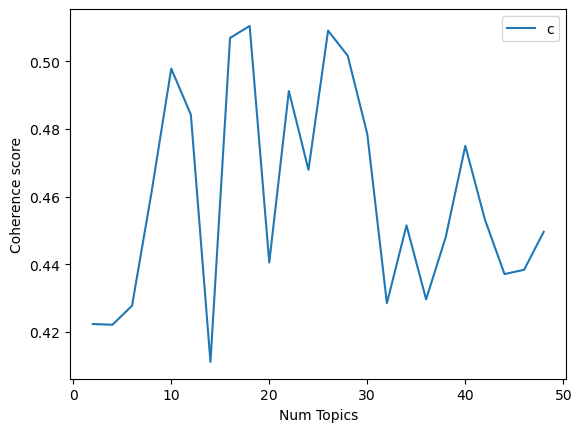

In [9]:
from tqdm import tqdm
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 
import logging 
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel 
import matplotlib.pyplot as plt 

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3): # 응집도 계산
    coherence_values = [] 
    model_list = [] 
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model) 
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence()) 
    return model_list, coherence_values 

def find_optimal_number_of_topics(dictionary, corpus, processed_data): # 토픽갯수별 응집도 그래프
    limit = 50; #토픽 마지막갯수
    start = 2; #토픽 시작갯수
    step = 2; ### 1개씩 해서 돌려보기 
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                            texts=processed_data, start=start, limit=limit, step=step) 
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best') 
    plt.show() 


processed_data = [sent.strip().split(",") for sent in tqdm(open('Dataset_preprocessed.csv', 'r', encoding='utf-8').readlines())]
dictionary = corpora.Dictionary(processed_data) 
dictionary.filter_extremes(no_below=10, no_above=0.05) # 출현빈도가 적거나 자주 등장하는 단어는 제거 
corpus = [dictionary.doc2bow(text) for text in processed_data]
print('Number of unique tokens: %d' % len(dictionary)) 
print('Number of documents: %d' % len(corpus))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 
    
# 최적의 토픽 수 찾기 
find_optimal_number_of_topics(dictionary, corpus, processed_data)

- 확인 결과 13~15개가 가장 좋아 보임

In [155]:
pd.DataFrame(tokenized_data).to_csv('tokenized_textdata.csv')

# LDA 토픽모델링

In [156]:
df

,키워드,토픽 번호
0,"한국탄소산업진흥원,탄소소부장,기업,애로,지원,박차,한국탄소산업진흥원,원장,방윤혁,소...",2
1,"자원순환,포장재,플라스틱,플라스틱,인류,발명,최고,선물,최악,산물,유용성,편리,장점...",9
2,"해변,불꽃놀이,불법,지구용,해수욕장법,폭죽,판매,합법,단속,인력,어둠,해변,파도,소...",12
3,"부경대,중학교,강연,청소년,해역,인문학,개최,국립,부경대학교,인문,한국플러스,HK,...",7
4,"부경대,중학교,강연,청소년,해역,인문학,개최,24일,27일,부흥중,국립,부경대학교,...",7
...,...,...
2395,"2년,IFA,삼성,LG,공개,가전,유럽,최대,가전,박람회,IFA,삼성,LG,참여,트...",3
2396,"수원사업장,부회장,이재용,삼성전자,MZ,세대,직원,소통,복권,대외,일정,현장,용인,...",3
2397,"가방,페트병,재활용,지구용,폐페트병,플리츠마마,니트백,사진,가방,용사님,브랜드,이름...",9
2398,"삼성전자,파타고니아,협력,공개,미세,플라스틱,저감,세탁기,삼성전자,글로벌,아웃도어,...",3


In [157]:
tokenized_doc = df['키워드'].apply(lambda x: x.split(','))
tokenized_doc

0       [한국탄소산업진흥원, 탄소소부장, 기업, 애로, 지원, 박차, 한국탄소산업진흥원, ...
1       [자원순환, 포장재, 플라스틱, 플라스틱, 인류, 발명, 최고, 선물, 최악, 산물...
2       [해변, 불꽃놀이, 불법, 지구용, 해수욕장법, 폭죽, 판매, 합법, 단속, 인력,...
3       [부경대, 중학교, 강연, 청소년, 해역, 인문학, 개최, 국립, 부경대학교, 인문...
4       [부경대, 중학교, 강연, 청소년, 해역, 인문학, 개최, 24일, 27일, 부흥중...
                              ...                        
2395    [2년, IFA, 삼성, LG, 공개, 가전, 유럽, 최대, 가전, 박람회, IFA...
2396    [수원사업장, 부회장, 이재용, 삼성전자, MZ, 세대, 직원, 소통, 복권, 대외...
2397    [가방, 페트병, 재활용, 지구용, 폐페트병, 플리츠마마, 니트백, 사진, 가방, ...
2398    [삼성전자, 파타고니아, 협력, 공개, 미세, 플라스틱, 저감, 세탁기, 삼성전자,...
2399    [해양, 생물, 위협, 플라스틱, 빨대, 지구, 이젠, 안녕, 사랑, 빨대, 연간,...
Name: 키워드, Length: 2400, dtype: object

In [158]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]

2023-01-03 21:03:46,616 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2023-01-03 21:03:46,959 : INFO : built Dictionary(52313 unique tokens: ['28건', '가교역할', '가능', '가능성', '가시적']...) from 2400 documents (total 554256 corpus positions)
2023-01-03 21:03:46,959 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(52313 unique tokens: ['28건', '가교역할', '가능', '가능성', '가시적']...) from 2400 documents (total 554256 corpus positions)", 'datetime': '2023-01-03T21:03:46.959816', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [168]:
import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

2023-01-03 21:07:10,319 : INFO : using symmetric alpha at 0.1
2023-01-03 21:07:10,321 : INFO : using symmetric eta at 0.1
2023-01-03 21:07:10,332 : INFO : using serial LDA version on this node
2023-01-03 21:07:10,371 : INFO : running online (multi-pass) LDA training, 10 topics, 15 passes over the supplied corpus of 2400 documents, updating model once every 2000 documents, evaluating perplexity every 2400 documents, iterating 50x with a convergence threshold of 0.001000
2023-01-03 21:07:10,372 : INFO : PROGRESS: pass 0, at document #2000/2400
2023-01-03 21:07:11,486 : INFO : merging changes from 2000 documents into a model of 2400 documents
2023-01-03 21:07:11,502 : INFO : topic #3 (0.100): 0.022*"플라스틱" + 0.014*"미세플라스틱" + 0.007*"환경" + 0.007*"사용" + 0.006*"해양" + 0.005*"쓰레기" + 0.004*"바다" + 0.004*"생태" + 0.004*"분해" + 0.004*"제품"
2023-01-03 21:07:11,503 : INFO : topic #9 (0.100): 0.011*"플라스틱" + 0.011*"미세플라스틱" + 0.008*"환경" + 0.007*"사용" + 0.006*"해양" + 0.005*"미세" + 0.005*"제품" + 0.005*"바다" + 0.004

2023-01-03 21:07:15,960 : INFO : topic #2 (0.100): 0.012*"환경" + 0.010*"사업" + 0.007*"분야" + 0.006*"산업" + 0.006*"탄소" + 0.005*"추진" + 0.005*"플라스틱" + 0.004*"미세플라스틱" + 0.004*"지원" + 0.004*"활용"
2023-01-03 21:07:15,961 : INFO : topic #1 (0.100): 0.046*"해양" + 0.032*"쓰레기" + 0.023*"바다" + 0.016*"부표" + 0.012*"수거" + 0.010*"해양쓰레기" + 0.009*"스티로폼" + 0.008*"관리" + 0.007*"미세플라스틱" + 0.007*"환경"
2023-01-03 21:07:15,962 : INFO : topic #5 (0.100): 0.007*"사회" + 0.006*"기업" + 0.006*"대표" + 0.005*"제품" + 0.004*"환경" + 0.004*"지원" + 0.004*"과학" + 0.004*"혁신" + 0.003*"선정" + 0.003*"학생"
2023-01-03 21:07:15,963 : INFO : topic #6 (0.100): 0.018*"마스크" + 0.008*"지구" + 0.008*"바다" + 0.006*"인간" + 0.005*"발생" + 0.005*"인류" + 0.005*"환경" + 0.005*"바이러스" + 0.004*"코로나19" + 0.004*"쓰레기"
2023-01-03 21:07:15,964 : INFO : topic diff=0.341278, rho=0.438529
2023-01-03 21:07:16,263 : INFO : -8.657 per-word bound, 403.5 perplexity estimate based on a held-out corpus of 400 documents with 93691 words
2023-01-03 21:07:16,264 : INFO : PROGRESS: pass 3, 

2023-01-03 21:07:19,942 : INFO : -8.328 per-word bound, 321.2 perplexity estimate based on a held-out corpus of 400 documents with 93691 words
2023-01-03 21:07:19,942 : INFO : PROGRESS: pass 6, at document #2400/2400
2023-01-03 21:07:20,074 : INFO : merging changes from 400 documents into a model of 2400 documents
2023-01-03 21:07:20,086 : INFO : topic #4 (0.100): 0.014*"쓰레기" + 0.013*"환경" + 0.012*"사용" + 0.010*"아이스팩" + 0.008*"플라스틱" + 0.008*"수거" + 0.006*"재활용" + 0.006*"캠페인" + 0.005*"미세플라스틱" + 0.005*"실천"
2023-01-03 21:07:20,087 : INFO : topic #6 (0.100): 0.013*"지구" + 0.012*"마스크" + 0.008*"인간" + 0.006*"발생" + 0.005*"바다" + 0.005*"인류" + 0.005*"기후" + 0.005*"사람" + 0.004*"동물" + 0.004*"환경"
2023-01-03 21:07:20,088 : INFO : topic #9 (0.100): 0.014*"삼성전자" + 0.014*"가전" + 0.013*"제품" + 0.013*"에너지" + 0.009*"세탁기" + 0.009*"미세" + 0.009*"유럽" + 0.007*"IFA" + 0.007*"저감" + 0.006*"최대"
2023-01-03 21:07:20,089 : INFO : topic #7 (0.100): 0.020*"제품" + 0.017*"플라스틱" + 0.014*"사용" + 0.011*"소재" + 0.011*"화장품" + 0.007*"생산" 

2023-01-03 21:07:23,503 : INFO : topic #4 (0.100): 0.014*"쓰레기" + 0.013*"환경" + 0.013*"사용" + 0.011*"아이스팩" + 0.008*"플라스틱" + 0.008*"수거" + 0.007*"재활용" + 0.006*"캠페인" + 0.005*"실천" + 0.004*"폐기물"
2023-01-03 21:07:23,504 : INFO : topic #7 (0.100): 0.021*"제품" + 0.017*"플라스틱" + 0.015*"사용" + 0.011*"소재" + 0.010*"화장품" + 0.007*"분해" + 0.007*"생산" + 0.007*"기업" + 0.006*"환경" + 0.006*"피부"
2023-01-03 21:07:23,504 : INFO : topic diff=0.112397, rho=0.298807
2023-01-03 21:07:23,505 : INFO : PROGRESS: pass 10, at document #2000/2400
2023-01-03 21:07:24,171 : INFO : merging changes from 2000 documents into a model of 2400 documents
2023-01-03 21:07:24,183 : INFO : topic #1 (0.100): 0.046*"해양" + 0.034*"쓰레기" + 0.023*"바다" + 0.014*"부표" + 0.012*"수거" + 0.010*"해양쓰레기" + 0.008*"관리" + 0.008*"스티로폼" + 0.008*"환경" + 0.008*"미세플라스틱"
2023-01-03 21:07:24,184 : INFO : topic #6 (0.100): 0.017*"마스크" + 0.014*"지구" + 0.009*"인간" + 0.006*"기후" + 0.006*"인류" + 0.006*"발생" + 0.005*"바다" + 0.005*"바이러스" + 0.005*"코로나19" + 0.005*"사람"
2023-01-03 21:0

2023-01-03 21:07:27,441 : INFO : topic #0 (0.100): 0.016*"담배꽁초" + 0.012*"미세플라스틱" + 0.010*"소금" + 0.006*"천일염" + 0.006*"필터" + 0.005*"수돗물" + 0.005*"검출" + 0.005*"오염" + 0.005*"세계" + 0.005*"바다"
2023-01-03 21:07:27,442 : INFO : topic #1 (0.100): 0.046*"해양" + 0.034*"쓰레기" + 0.023*"바다" + 0.014*"부표" + 0.012*"수거" + 0.010*"해양쓰레기" + 0.008*"관리" + 0.008*"스티로폼" + 0.008*"환경" + 0.007*"미세플라스틱"
2023-01-03 21:07:27,443 : INFO : topic #6 (0.100): 0.016*"마스크" + 0.015*"지구" + 0.009*"인간" + 0.007*"기후" + 0.006*"인류" + 0.005*"발생" + 0.005*"바다" + 0.005*"기후변화" + 0.005*"바이러스" + 0.005*"사람"
2023-01-03 21:07:27,445 : INFO : topic #8 (0.100): 0.072*"플라스틱" + 0.040*"미세플라스틱" + 0.014*"바다" + 0.013*"사용" + 0.012*"쓰레기" + 0.011*"미세" + 0.008*"오염" + 0.008*"세계" + 0.007*"결과" + 0.007*"해양"
2023-01-03 21:07:27,445 : INFO : topic diff=0.089315, rho=0.256495
2023-01-03 21:07:27,719 : INFO : -8.144 per-word bound, 282.9 perplexity estimate based on a held-out corpus of 400 documents with 93691 words
2023-01-03 21:07:27,720 : INFO : PROGRESS: p

(0, '0.014*"담배꽁초" + 0.011*"미세플라스틱" + 0.010*"소금" + 0.006*"천일염"')
(1, '0.046*"해양" + 0.033*"쓰레기" + 0.022*"바다" + 0.015*"부표"')
(2, '0.012*"환경" + 0.011*"사업" + 0.008*"산업" + 0.007*"분야"')
(3, '0.012*"나노플라스틱" + 0.012*"생태" + 0.008*"영향" + 0.006*"참조기"')
(4, '0.014*"쓰레기" + 0.014*"사용" + 0.013*"환경" + 0.011*"아이스팩"')
(5, '0.006*"사회" + 0.006*"대표" + 0.005*"기업" + 0.004*"학생"')
(6, '0.016*"지구" + 0.012*"마스크" + 0.009*"인간" + 0.007*"기후"')
(7, '0.022*"제품" + 0.017*"플라스틱" + 0.016*"사용" + 0.011*"소재"')
(8, '0.072*"플라스틱" + 0.040*"미세플라스틱" + 0.014*"바다" + 0.013*"사용"')
(9, '0.014*"삼성전자" + 0.014*"가전" + 0.012*"제품" + 0.012*"에너지"')


In [169]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [170]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [171]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']
topictable[:10]

/var/folders/gx/q7vn3yv17rvb0vy6chbbbztw0000gn/T/ipykernel_5055/3045163963.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
/var/folders/gx/q7vn3yv17rvb0vy6chbbbztw0000gn/T/ipykernel_5055/3045163963.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)


,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,5,0.4273,"[(1, 0.09332143), (2, 0.28967953), (4, 0.03084..."
1,1,4,0.4544,"[(2, 0.07779944), (4, 0.4543577), (7, 0.338213..."
2,2,0,0.5028,"[(0, 0.50284374), (1, 0.1371363), (4, 0.283677..."
3,3,5,0.3756,"[(1, 0.27908394), (2, 0.33879185), (5, 0.37562..."
4,4,5,0.3660,"[(1, 0.28042245), (2, 0.34734607), (5, 0.36599..."
5,5,5,0.4511,"[(2, 0.078795806), (3, 0.01177366), (4, 0.0928..."
6,6,8,0.4697,"[(2, 0.06468921), (4, 0.45063698), (8, 0.46974..."
7,7,8,0.4439,"[(1, 0.074169755), (2, 0.17266136), (4, 0.3064..."
8,8,5,0.8310,"[(5, 0.83097535), (7, 0.10489815), (8, 0.06040..."
9,9,8,0.6430,"[(0, 0.06312059), (4, 0.13905618), (7, 0.15162..."


## 토픽모델링 토픽 분류 및 군집화

In [172]:
topictable['가장 비중이 높은 토픽'] = topictable['가장 비중이 높은 토픽'] + 1
topictable.head(10)

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,6,0.4273,"[(1, 0.09332143), (2, 0.28967953), (4, 0.03084..."
1,1,5,0.4544,"[(2, 0.07779944), (4, 0.4543577), (7, 0.338213..."
2,2,1,0.5028,"[(0, 0.50284374), (1, 0.1371363), (4, 0.283677..."
3,3,6,0.3756,"[(1, 0.27908394), (2, 0.33879185), (5, 0.37562..."
4,4,6,0.3660,"[(1, 0.28042245), (2, 0.34734607), (5, 0.36599..."
5,5,6,0.4511,"[(2, 0.078795806), (3, 0.01177366), (4, 0.0928..."
6,6,9,0.4697,"[(2, 0.06468921), (4, 0.45063698), (8, 0.46974..."
7,7,9,0.4439,"[(1, 0.074169755), (2, 0.17266136), (4, 0.3064..."
8,8,6,0.8310,"[(5, 0.83097535), (7, 0.10489815), (8, 0.06040..."
9,9,9,0.6430,"[(0, 0.06312059), (4, 0.13905618), (7, 0.15162..."


In [173]:
# 토픽 번호를 첨부함으로서 어떤 주제인지 찾을 수 있게 분류
df['토픽 번호'] = topictable['가장 비중이 높은 토픽']
df.head()

,키워드,토픽 번호
0,"한국탄소산업진흥원,탄소소부장,기업,애로,지원,박차,한국탄소산업진흥원,원장,방윤혁,소...",6
1,"자원순환,포장재,플라스틱,플라스틱,인류,발명,최고,선물,최악,산물,유용성,편리,장점...",5
2,"해변,불꽃놀이,불법,지구용,해수욕장법,폭죽,판매,합법,단속,인력,어둠,해변,파도,소...",1
3,"부경대,중학교,강연,청소년,해역,인문학,개최,국립,부경대학교,인문,한국플러스,HK,...",6
4,"부경대,중학교,강연,청소년,해역,인문학,개최,24일,27일,부흥중,국립,부경대학교,...",6


In [178]:
df.to_csv('10개토픽모델링버전.csv', encoding = 'utf-8-sig')

In [179]:
topictable.to_csv('10개토픽테이블.csv', encoding = 'utf-8-sig')

In [174]:
pyLDAvis.save_html(vis, '토픽모델링결과10개버전.html')

In [175]:
# 토픽이 제대로 분류되었는지 확인
df['토픽 번호'].value_counts()

9     605
5     579
2     299
8     248
3     180
6     169
1     156
7      74
10     54
4      36
Name: 토픽 번호, dtype: int64

/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.p

/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.p

In [130]:
word_counts

[1, 1]

In [57]:
# 명사만 추출
tkdf = pd.DataFrame(tokenized_doc)
tkdf

,키워드
0,"[한국탄소산업진흥원, 탄소소부장, 기업, 애로, 지원, 박차, 한국탄소산업진흥원, ..."
1,"[자원순환, 포장재, 플라스틱, 플라스틱, 인류, 발명, 최고, 선물, 최악, 산물..."
2,"[해변, 불꽃놀이, 불법, 지구용, 해수욕장법, 폭죽, 판매, 합법, 단속, 인력,..."
3,"[부경대, 중학교, 강연, 청소년, 해역, 인문학, 개최, 국립, 부경대학교, 인문..."
4,"[부경대, 중학교, 강연, 청소년, 해역, 인문학, 개최, 24일, 27일, 부흥중..."
...,...
2395,"[2년, IFA, 삼성, LG, 공개, 가전, 유럽, 최대, 가전, 박람회, IFA..."
2396,"[수원사업장, 부회장, 이재용, 삼성전자, MZ, 세대, 직원, 소통, 복권, 대외..."
2397,"[가방, 페트병, 재활용, 지구용, 폐페트병, 플리츠마마, 니트백, 사진, 가방, ..."
2398,"[삼성전자, 파타고니아, 협력, 공개, 미세, 플라스틱, 저감, 세탁기, 삼성전자,..."


In [61]:
okt.nouns(df['키워드'][0])

['한국',
 '탄소',
 '산업',
 '진흥',
 '탄소',
 '부장',
 '기업',
 '애로',
 '지원',
 '박차',
 '한국',
 '탄소',
 '산업',
 '진흥',
 '원장',
 '방',
 '윤혁',
 '소재',
 '탄소',
 '부품',
 '장비',
 '기업',
 '현장',
 '기술',
 '애',
 '해결',
 '추진',
 '기술',
 '지원',
 '사업',
 '융합',
 '혁신',
 '원단',
 '지원',
 '사업',
 '가시',
 '성과',
 '진흥',
 '지난달',
 '부장',
 '혁신',
 '지원',
 '사업',
 '기초',
 '소재',
 '분과',
 '본격',
 '참여',
 '건',
 '기술',
 '애',
 '단기',
 '지원',
 '융합',
 '지원',
 '사업',
 '추진',
 '탄소',
 '소재',
 '강도',
 '탄성',
 '부식',
 '마모',
 '장점',
 '첨단',
 '소재',
 '각광',
 '우주',
 '항공',
 '방산',
 '자동차',
 '풍력',
 '블레이드',
 '환경',
 '정화',
 '필터',
 '산업',
 '소재',
 '활용',
 '실용',
 '전문성',
 '분야',
 '진흥',
 '소부',
 '장혁',
 '신지원',
 '사업',
 '계기',
 '기술',
 '정보',
 '설계',
 '해석',
 '제품',
 '특성',
 '평가',
 '사업',
 '탄소',
 '부장',
 '기업',
 '해결',
 '컨설팅',
 '내부',
 '전문가',
 '현장',
 '밀착',
 '추진',
 '실제',
 '해양',
 '미세',
 '플라스틱',
 '수거',
 '장치',
 '대성',
 '중공업',
 '장치',
 '부식',
 '변형',
 '소재',
 '가능성',
 '탄소',
 '섬유',
 '복합재',
 '적용',
 '가능',
 '전문가',
 '검토',
 '수거',
 '장치',
 '장시간',
 '바다',
 '투입',
 '쓰레기',
 '수거',
 '분류',
 '파쇄',
 '가능',
 '특허',
 '출원',
 '재생',
 '탄소섬유',
 '생산',

In [63]:
tkdf['명사키워드']=0
for i in range(len(df['키워드'])):
    tkdf['명사키워드'][i] = okt.nouns(df['키워드'][i])

/var/folders/gx/q7vn3yv17rvb0vy6chbbbztw0000gn/T/ipykernel_6035/4163302202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tkdf['명사키워드'][i] = okt.nouns(df['키워드'][i])


In [65]:
tkdf['명사키워드']

0       [한국, 탄소, 산업, 진흥, 탄소, 부장, 기업, 애로, 지원, 박차, 한국, 탄...
1       [자원, 순환, 포장재, 플라스틱, 플라스틱, 인류, 발명, 최고, 선물, 최악, ...
2       [해변, 불꽃놀이, 불법, 지구, 용, 해수욕장, 법, 폭죽, 판매, 합법, 단속,...
3       [부경대, 중학교, 강연, 청소년, 해역, 인문학, 개최, 국립, 부경대학교, 인문...
4       [부경대, 중학교, 강연, 청소년, 해역, 인문학, 개최, 부흥, 국립, 부경대학교...
                              ...                        
2395    [삼성, 공개, 가전, 유럽, 최대, 가전, 박람회, 삼성, 참여, 트렌드, 세계,...
2396    [사업, 부회장, 이재용, 삼성, 전자, 세대, 직원, 소통, 복권, 대외, 일정,...
2397    [가방, 페트병, 재활용, 지구, 용, 폐, 페트병, 리츠, 마마, 니트, 사진, ...
2398    [삼성, 전자, 파타고니아, 협력, 공개, 미세, 플라스틱, 감, 세탁기, 삼성, ...
2399    [해양, 생물, 위협, 플라스틱, 빨대, 지구, 젠, 안녕, 사랑, 빨대, 연간, ...
Name: 명사키워드, Length: 2400, dtype: object

In [68]:
tokenized_doc2 = tkdf['명사키워드']
tokenized_doc2

0       [한국, 탄소, 산업, 진흥, 탄소, 부장, 기업, 애로, 지원, 박차, 한국, 탄...
1       [자원, 순환, 포장재, 플라스틱, 플라스틱, 인류, 발명, 최고, 선물, 최악, ...
2       [해변, 불꽃놀이, 불법, 지구, 용, 해수욕장, 법, 폭죽, 판매, 합법, 단속,...
3       [부경대, 중학교, 강연, 청소년, 해역, 인문학, 개최, 국립, 부경대학교, 인문...
4       [부경대, 중학교, 강연, 청소년, 해역, 인문학, 개최, 부흥, 국립, 부경대학교...
                              ...                        
2395    [삼성, 공개, 가전, 유럽, 최대, 가전, 박람회, 삼성, 참여, 트렌드, 세계,...
2396    [사업, 부회장, 이재용, 삼성, 전자, 세대, 직원, 소통, 복권, 대외, 일정,...
2397    [가방, 페트병, 재활용, 지구, 용, 폐, 페트병, 리츠, 마마, 니트, 사진, ...
2398    [삼성, 전자, 파타고니아, 협력, 공개, 미세, 플라스틱, 감, 세탁기, 삼성, ...
2399    [해양, 생물, 위협, 플라스틱, 빨대, 지구, 젠, 안녕, 사랑, 빨대, 연간, ...
Name: 명사키워드, Length: 2400, dtype: object

In [69]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_doc2)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc2]

2022-12-31 15:27:16,625 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-12-31 15:27:16,962 : INFO : built Dictionary(22763 unique tokens: ['가교', '가능', '가능성', '가시', '각광']...) from 2400 documents (total 593201 corpus positions)
2022-12-31 15:27:16,963 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(22763 unique tokens: ['가교', '가능', '가능성', '가시', '각광']...) from 2400 documents (total 593201 corpus positions)", 'datetime': '2022-12-31T15:27:16.963374', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [76]:
import gensim
NUM_TOPICS = 13
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

2022-12-31 15:32:09,756 : INFO : using symmetric alpha at 0.07692307692307693
2022-12-31 15:32:09,758 : INFO : using symmetric eta at 0.07692307692307693
2022-12-31 15:32:09,766 : INFO : using serial LDA version on this node
2022-12-31 15:32:09,792 : INFO : running online (multi-pass) LDA training, 13 topics, 15 passes over the supplied corpus of 2400 documents, updating model once every 2000 documents, evaluating perplexity every 2400 documents, iterating 50x with a convergence threshold of 0.001000
2022-12-31 15:32:09,793 : INFO : PROGRESS: pass 0, at document #2000/2400
2022-12-31 15:32:10,848 : INFO : merging changes from 2000 documents into a model of 2400 documents
2022-12-31 15:32:10,856 : INFO : topic #9 (0.077): 0.012*"플라스틱" + 0.008*"환경" + 0.008*"사용" + 0.006*"해양" + 0.005*"제품" + 0.005*"쓰레기" + 0.005*"오염" + 0.004*"미세" + 0.004*"지역" + 0.004*"물질"
2022-12-31 15:32:10,857 : INFO : topic #11 (0.077): 0.015*"쓰레기" + 0.014*"플라스틱" + 0.008*"미세" + 0.007*"해양" + 0.007*"환경" + 0.005*"제품" + 0.005

2022-12-31 15:32:15,019 : INFO : topic #2 (0.077): 0.042*"플라스틱" + 0.038*"쓰레기" + 0.016*"해양" + 0.015*"바다" + 0.013*"미세" + 0.010*"폐" + 0.008*"바다거북" + 0.007*"재활용" + 0.006*"세계" + 0.006*"폐기물"
2022-12-31 15:32:15,019 : INFO : topic #5 (0.077): 0.013*"교수" + 0.012*"환경" + 0.011*"과학" + 0.008*"분야" + 0.008*"한국" + 0.007*"아이디어" + 0.007*"학생" + 0.007*"진행" + 0.006*"체험" + 0.006*"선정"
2022-12-31 15:32:15,020 : INFO : topic #9 (0.077): 0.025*"현수막" + 0.015*"피부" + 0.014*"시험" + 0.014*"화장품" + 0.009*"연구소" + 0.008*"인증" + 0.008*"사용" + 0.007*"선거" + 0.007*"환경" + 0.006*"연구원"
2022-12-31 15:32:15,021 : INFO : topic #11 (0.077): 0.014*"세포" + 0.013*"콜라겐" + 0.008*"피부" + 0.007*"행주" + 0.006*"로봇" + 0.006*"제품" + 0.006*"위생" + 0.006*"데이터" + 0.005*"식품" + 0.005*"안전"
2022-12-31 15:32:15,022 : INFO : topic diff=0.417727, rho=0.438529
2022-12-31 15:32:15,293 : INFO : -7.786 per-word bound, 220.8 perplexity estimate based on a held-out corpus of 400 documents with 98901 words
2022-12-31 15:32:15,293 : INFO : PROGRESS: pass 3, at docum

2022-12-31 15:32:18,885 : INFO : PROGRESS: pass 6, at document #2400/2400
2022-12-31 15:32:19,019 : INFO : merging changes from 400 documents into a model of 2400 documents
2022-12-31 15:32:19,026 : INFO : topic #6 (0.077): 0.014*"전자" + 0.012*"삼성" + 0.011*"가전" + 0.011*"환경" + 0.010*"에너지" + 0.009*"사회" + 0.007*"제품" + 0.007*"스마트" + 0.006*"실천" + 0.006*"기업"
2022-12-31 15:32:19,027 : INFO : topic #3 (0.077): 0.053*"소금" + 0.031*"천일염" + 0.014*"디자인" + 0.011*"학생" + 0.010*"미네랄" + 0.008*"디" + 0.008*"공모전" + 0.008*"수상" + 0.007*"제품" + 0.006*"인공"
2022-12-31 15:32:19,027 : INFO : topic #12 (0.077): 0.025*"지구" + 0.023*"기후" + 0.013*"위기" + 0.011*"플라스틱" + 0.010*"세계" + 0.009*"발생" + 0.009*"기후변화" + 0.008*"탄소" + 0.008*"인간" + 0.007*"변화"
2022-12-31 15:32:19,028 : INFO : topic #2 (0.077): 0.061*"쓰레기" + 0.045*"플라스틱" + 0.020*"바다" + 0.017*"해양" + 0.013*"폐" + 0.011*"미세" + 0.009*"세계" + 0.008*"폐기물" + 0.008*"재활용" + 0.008*"바다거북"
2022-12-31 15:32:19,029 : INFO : topic #7 (0.077): 0.052*"담배" + 0.045*"꽁초" + 0.020*"필터" + 0.015

2022-12-31 15:32:22,519 : INFO : topic #8 (0.077): 0.020*"제품" + 0.015*"사용" + 0.014*"플라스틱" + 0.010*"빨대" + 0.007*"환경" + 0.007*"물티슈" + 0.007*"미세" + 0.007*"사람" + 0.007*"대표" + 0.005*"가능"
2022-12-31 15:32:22,520 : INFO : topic diff=0.098907, rho=0.298807
2022-12-31 15:32:22,520 : INFO : PROGRESS: pass 10, at document #2000/2400
2022-12-31 15:32:23,252 : INFO : merging changes from 2000 documents into a model of 2400 documents
2022-12-31 15:32:23,259 : INFO : topic #6 (0.077): 0.012*"전자" + 0.012*"환경" + 0.011*"삼성" + 0.010*"사회" + 0.009*"가전" + 0.009*"에너지" + 0.007*"제품" + 0.007*"실천" + 0.007*"교육" + 0.006*"기업"
2022-12-31 15:32:23,260 : INFO : topic #7 (0.077): 0.058*"담배" + 0.051*"꽁초" + 0.021*"필터" + 0.015*"수돗물" + 0.010*"하수" + 0.010*"캠페인" + 0.009*"수질" + 0.009*"처리" + 0.009*"정수" + 0.009*"수거"
2022-12-31 15:32:23,261 : INFO : topic #2 (0.077): 0.077*"쓰레기" + 0.045*"플라스틱" + 0.025*"바다" + 0.016*"해양" + 0.013*"폐" + 0.009*"세계" + 0.009*"바다거북" + 0.009*"미세" + 0.008*"폐기물" + 0.007*"중국"
2022-12-31 15:32:23,262 : INFO 

2022-12-31 15:32:26,671 : INFO : topic #1 (0.077): 0.021*"사용" + 0.019*"아이스팩" + 0.012*"플라스틱" + 0.012*"재활용" + 0.012*"수거" + 0.011*"쓰레기" + 0.009*"환경" + 0.009*"배출" + 0.008*"비닐" + 0.007*"폐기물"
2022-12-31 15:32:26,672 : INFO : topic #6 (0.077): 0.013*"전자" + 0.012*"환경" + 0.011*"삼성" + 0.010*"사회" + 0.010*"가전" + 0.009*"에너지" + 0.008*"제품" + 0.007*"기업" + 0.006*"스마트" + 0.006*"실천"
2022-12-31 15:32:26,672 : INFO : topic diff=0.076427, rho=0.256495
2022-12-31 15:32:26,929 : INFO : -7.633 per-word bound, 198.5 perplexity estimate based on a held-out corpus of 400 documents with 98901 words
2022-12-31 15:32:26,929 : INFO : PROGRESS: pass 13, at document #2400/2400
2022-12-31 15:32:27,059 : INFO : merging changes from 400 documents into a model of 2400 documents
2022-12-31 15:32:27,066 : INFO : topic #4 (0.077): 0.105*"플라스틱" + 0.053*"미세" + 0.012*"바다" + 0.012*"사용" + 0.011*"오염" + 0.010*"해양" + 0.008*"물질" + 0.008*"세계" + 0.008*"환경" + 0.008*"영향"
2022-12-31 15:32:27,067 : INFO : topic #9 (0.077): 0.038*"화장품" + 0.0

(0, '0.017*"플라스틱" + 0.013*"산업" + 0.013*"기업" + 0.012*"생산"')
(1, '0.023*"사용" + 0.016*"아이스팩" + 0.013*"플라스틱" + 0.013*"재활용"')
(2, '0.083*"쓰레기" + 0.047*"플라스틱" + 0.028*"바다" + 0.017*"해양"')
(3, '0.058*"소금" + 0.032*"천일염" + 0.014*"디자인" + 0.011*"미네랄"')
(4, '0.106*"플라스틱" + 0.054*"미세" + 0.012*"바다" + 0.012*"사용"')
(5, '0.016*"환경" + 0.014*"학생" + 0.012*"교수" + 0.012*"과학"')
(6, '0.014*"전자" + 0.013*"삼성" + 0.012*"가전" + 0.011*"환경"')
(7, '0.052*"담배" + 0.045*"꽁초" + 0.021*"필터" + 0.015*"수돗물"')
(8, '0.021*"제품" + 0.016*"사용" + 0.013*"플라스틱" + 0.011*"빨대"')
(9, '0.038*"화장품" + 0.020*"피부" + 0.019*"현수막" + 0.014*"시험"')
(10, '0.049*"해양" + 0.026*"쓰레기" + 0.022*"환경" + 0.013*"바다"')
(11, '0.019*"세포" + 0.019*"콜라겐" + 0.011*"피부" + 0.010*"식물"')
(12, '0.032*"지구" + 0.024*"기후" + 0.015*"위기" + 0.011*"변화"')


In [77]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/Users/leeshinhaeng/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [78]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']
topictable[:10]

/var/folders/gx/q7vn3yv17rvb0vy6chbbbztw0000gn/T/ipykernel_6035/3045163963.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
/var/folders/gx/q7vn3yv17rvb0vy6chbbbztw0000gn/T/ipykernel_6035/3045163963.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)


,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,0,0.8054,"[(0, 0.80535436), (5, 0.045505997), (8, 0.0475..."
1,1,0,0.4471,"[(0, 0.44714478), (1, 0.37521815), (4, 0.09203..."
2,2,1,0.5292,"[(1, 0.52920514), (2, 0.27658698), (4, 0.01169..."
3,3,10,0.4586,"[(0, 0.055220228), (5, 0.43990484), (6, 0.0404..."
4,4,10,0.4746,"[(0, 0.07721471), (5, 0.4086055), (6, 0.033983..."
5,5,0,0.2795,"[(0, 0.27950916), (1, 0.035320617), (5, 0.1774..."
6,6,4,0.3660,"[(0, 0.06077453), (1, 0.11404275), (4, 0.36596..."
7,7,10,0.3116,"[(0, 0.1491692), (1, 0.10546124), (4, 0.274162..."
8,8,0,0.4426,"[(0, 0.44255614), (4, 0.032993656), (6, 0.1147..."
9,9,4,0.5485,"[(0, 0.17463742), (1, 0.272625), (4, 0.5485045)]"


### 1차 결론
- 명사들끼리만 나누고 토픽 모델링을 실행한 것이, 그냥 토픽모델링을 실행한 것 보다는 결과가 좋게 나온 것 같다.

In [176]:
print(1)

1
